## Pressure sensor placement for leakage detection


### Initialize EPANET Python Toolkit (EPyT)

You should always begin with this command to import the toolkit.

[EPyT](https://github.com/OpenWaterAnalytics/EPyT) is available on [PyPI](https://pypi.org/project/epyt/) and can be installed via `pip install epyt`. To upgrade to the latest version if it's already installed, use `pip install --upgrade epyt`.

In [296]:
%pip install epyt pymoo

Note: you may need to restart the kernel to use updated packages.


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


In [297]:
%pip install numpy==1.23

Note: you may need to restart the kernel to use updated packages.


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


### Download data

In [298]:
import requests

url = "https://raw.githubusercontent.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/main/data/Hanoi.inp?token=GHSAT0AAAAAACTQ7OWEQMMHP5BC7ZRAI5JKZT5MS7A"
file_path = "Hanoi.inp"

try:
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded and saved as {file_path}")
except requests.exceptions.HTTPError as err:
    print(f"HTTP error occurred: {err}")
except Exception as err:
    print(f"An error occurred: {err}")


HTTP error occurred: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial/main/data/Hanoi.inp?token=GHSAT0AAAAAACTQ7OWEQMMHP5BC7ZRAI5JKZT5MS7A


In [299]:
from epyt import epanet

import numpy as np

from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
import matplotlib.pyplot as plt

### Water Network

In [300]:
# Load the water network model
d=epanet('Hanoi.inp')

EPANET version 20200 loaded (EPyT version v1.1.9 - Last Update: 24/06/2024).
Input File Hanoi.inp loaded successfully.



In [301]:
# Get the number of junctions and nodes
nj = d.getNodeJunctionCount()
nn = d.getNodeCount()
d.printv(nj)
d.printv(nn)

nj = 31
nn = 32


In [302]:
reservoir_indices = d.getNodeReservoirIndex()
junction_indices = d.getNodeJunctionIndex()
junction_indices_py = np.array(junction_indices) - 1

d.printv(reservoir_indices)
d.printv(junction_indices_py) 

reservoir_indices = [32]
junction_indices_py = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


### Calculate Sensitivity matrix
[1] Cugueró , M., Puig, V., Quevedo, J. Optimal pressure sensor placement and assessment for leak location using a relaxed isolation index: Application to the Barcelona water network, Control Eng. Pract., vol. 63, pp. 1-12, Jun. 2017.

##### Calculate healthy states in extended time simulation

In [303]:
d.setTimeSimulationDuration(24 * 60 * 60)  # greater weight to low demand hours
d.setTimePatternStart(0)  # in seconds

allParameters = d.getComputedTimeSeries()
P0 = allParameters.Pressure[:, junction_indices_py].T
Dem0 = allParameters.Demand[:, junction_indices_py].T
simSteps = P0.shape[1]

# Create Augmented-time Sensitivity Matrix
# Simulate all leakages and get all scenarios pressures
leak_mag_desir = np.mean(np.mean(Dem0[Dem0 > 0]))
mean_pressure = np.mean(np.mean(P0[P0 > 0]))

leak_emit = leak_mag_desir / np.sqrt(mean_pressure)
emit0 = d.getNodeEmitterCoeff()
S = np.zeros((nj, nj))

for leak in range(1, nj + 1):
    print('Calculating Sensitivity Matrix...')
    print('Simulating leakage', leak, 'out of', nj)
    emit = np.zeros_like(emit0)
    emit[leak - 1] = leak_emit  # set emitter coefficient (leakage) value
    d.setNodeEmitterCoeff(emit)

    allParameters = d.getComputedTimeSeries()

    P = allParameters.Pressure[:, junction_indices_py].T
    Dem = allParameters.Demand[:, junction_indices_py].T
    leak_mag = Dem[leak - 1, :] - Dem0[leak - 1, :]
    Stmp = (P - P0) / leak_mag
    rmax = np.max(np.abs(Stmp), axis=0)
    Stmp = np.abs(Stmp) / rmax
    S[:, leak - 1] = np.max(Stmp, axis=1)

print('Calculations done!')


Calculating Sensitivity Matrix...
Simulating leakage 1 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 2 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 3 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 4 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 5 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 6 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 7 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 8 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 9 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 10 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 11 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 12 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 13 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 14 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 15 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 16 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 17 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 18 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 19 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 20 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 21 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 22 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 23 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 24 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 25 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 26 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 27 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 28 out of 31


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


Calculating Sensitivity Matrix...
Simulating leakage 29 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 30 out of 31
Calculating Sensitivity Matrix...
Simulating leakage 31 out of 31
Calculations done!


C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())
C:\Users\mkiri\anaconda3\envs\tutorial_epyt\lib\site-packages\epyt\epanet.py:14320: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


### Place sensors using GA
Select number of sensors to be installed:

In [304]:
sensors_num = 4

Define existing sensors in the network

In [305]:
exist_sens_ind = []; # Define existing sensors in the network
# exist_sens_ind=d.getNodeIndex({'14','63','114','399','572','302','662'});

##### Solve using GA: Maximize the minimum sensitivity of all sensors to any leakage

In [306]:
#### Sensor Placement optimization problem - Cost function

In [340]:
# Cost function: min sensitivity of all leaks
def GACostFunction(u, S):
    Sm = S[u > 0, :]
    Smax = np.max(Sm, axis=0)
    # cost = 1 - np.min(Smax)-0.1*np.mean(Smax)
    cost = 1-np.min(Smax)
    # cost = 1-np.max(Smax)
    return cost
    
# Sensor placement optimization problem for a genetic algorithm. It sets up the problem
# dimensions, variable bounds, and defines how to evaluate each solution's fitness using
# the provided cost function (GACostFunction). The genetic algorithm can then use this
# problem definition to evolve sensor placement configurations towards an optimal solution.
class SensorPlacementProblem(Problem):
    def __init__(self, S, nj, sensors_num, exist_sens_ind):
        self.S = S
        self.nj = nj
        self.sensors_num = sensors_num
        self.exist_sens_ind = exist_sens_ind
        super().__init__(n_var=nj, n_obj=1, n_constr=0, xl=0, xu=nj-1, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        f = np.array([GACostFunction(xi, self.S) for xi in x])
        out["F"] = f

In [341]:
problem = SensorPlacementProblem(S, nj, sensors_num, exist_sens_ind)

In [347]:
# Configure the Genetic Algorithm (GA)
algorithm2 = GA(
    n_offsprings=5,
    pop_size=200,  # Population size
    sampling=IntegerRandomSampling(),  # Correctly specified sampling method
    crossover=SimulatedBinaryCrossover(eta=3, prob=1.0),  # Correctly specified crossover method
    # eta determines how closely the offspring are clustered around the parent solutions
    mutation=PolynomialMutation(eta=3, prob=1.0)  # Correctly specified mutation method
)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=50,  # Generate 50 offsprings in each generation
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)


In [348]:
# Solve the optimization problem
res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               #  multiple criteria (x_tol for tolerance, n_gen for maximum generations,
               #  and n_last for stall generations - terminates if there is no improvement
               #  in the last 5 generations)
               seed=1,  # The seed=1 is used to ensure reproducibility of results.
               verbose=True)  # flag is included to provide detailed output during the optimization process.
# Extract the result
u = res.X
print(u)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     31 |             - |             -
     2 |      150 |     62 |  0.000000E+00 |             f
     3 |      200 |    100 |  0.000000E+00 |             f
     4 |      250 |    100 |  0.000000E+00 |             f
     5 |      300 |    100 |  0.000000E+00 |             f
     6 |      350 |    100 |  0.000000E+00 |             f
     7 |      400 |    100 |  0.000000E+00 |             f
     8 |      450 |    100 |  0.000000E+00 |             f
     9 |      500 |    100 |  0.000000E+00 |             f
    10 |      550 |    100 |  0.000000E+00 |             f
    11 |      600 |    100 |  0.000000E+00 |             f
    12 |      650 |    100 |  0.000000E+00 |             f
    13 |      700 |    100 |  0.000000E+00 |             f
    14 |      750 |    100 |  0.000000E+00 |             f
    15 |      800 |    100 |  0.000000E+00 |             f
    16 |      850 |    100 |  0.000000E+00 |            

#### Plot sensors

[19 17 18  6]
['21', '19', '20', '8']


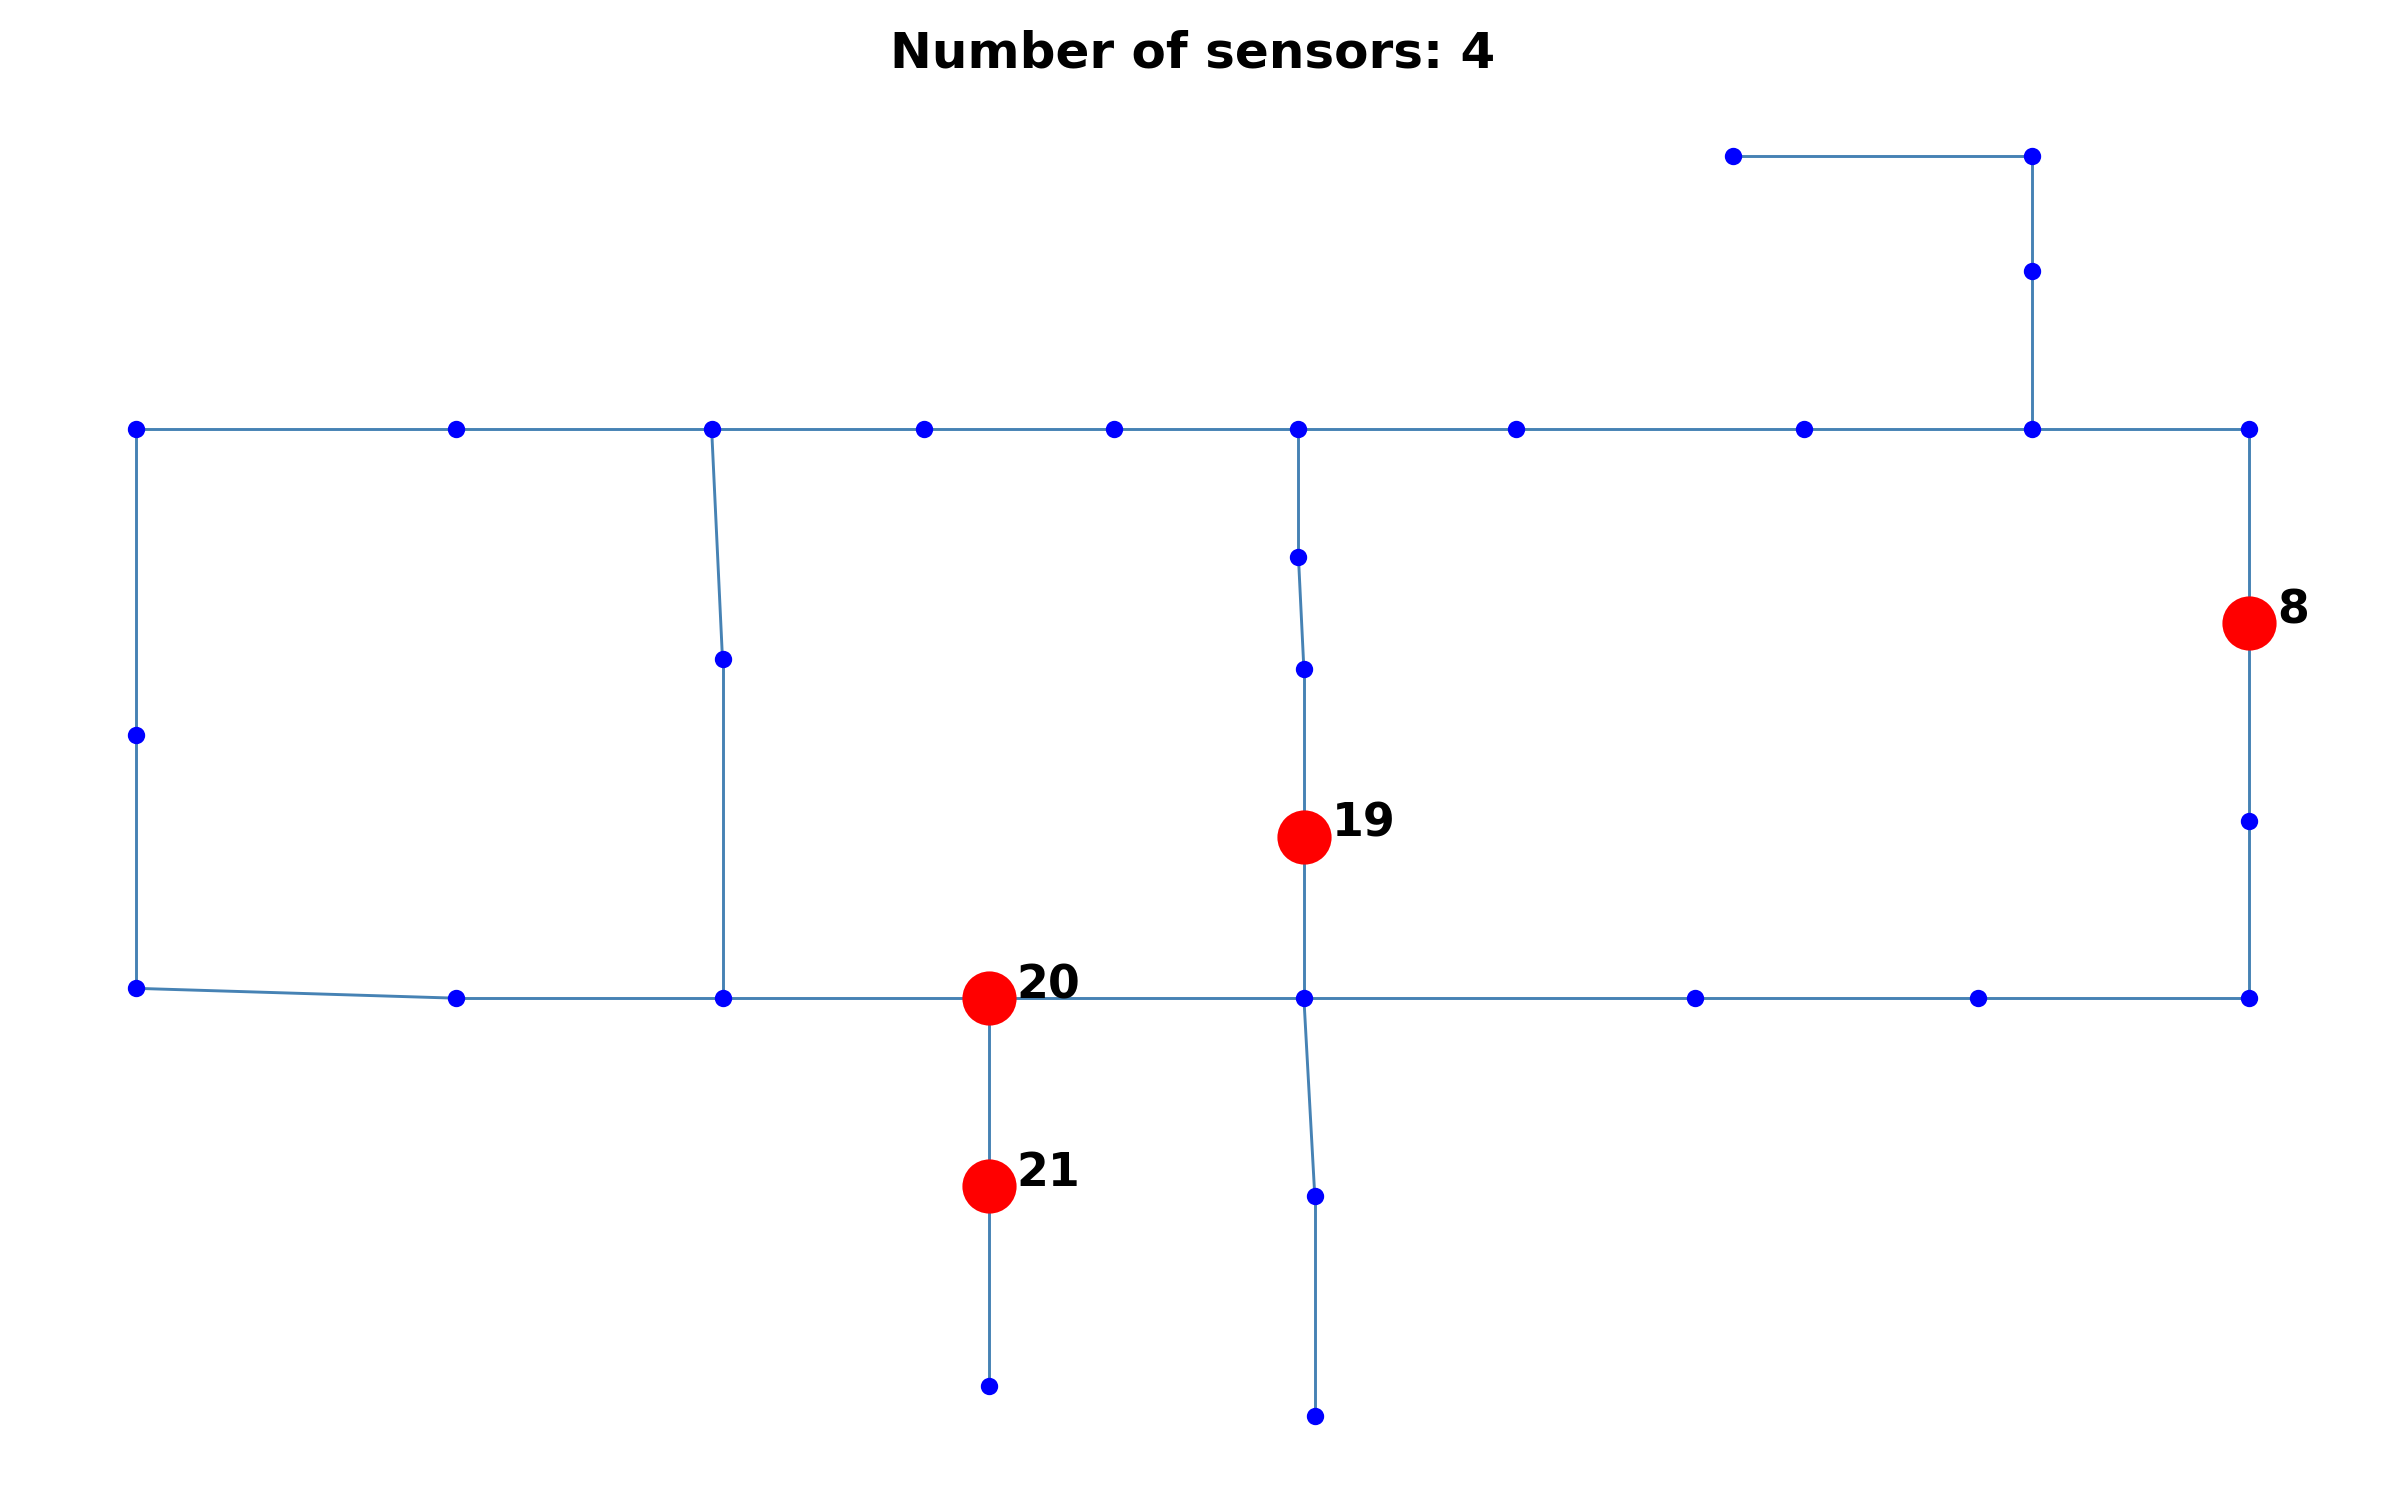

In [346]:
# Get indices of top sensors
top_sensors_indices = np.argsort(u)[-sensors_num:][::-1]

print(top_sensors_indices)
senors_ids = d.getNodeNameID(list(top_sensors_indices + 1))
# print("Indices of top", sensors_num, "selected sensors:", senors_ids)

# Load optimal solution (for demonstration only!)
sens_IDs_demonstration = ['13', '16', '22', '30']
# wntr: ['10', '17', '27', '32'], ['12', '15', '17', '27'], ['12', '17', '27', '30'], ['13', '17', '21', '30'], ['16', '22', '29', '30']
sens_ind = d.getNodeIndex(senors_ids)
print(senors_ids)

def custom_plot(coor):
    x_nodes = list(coor['x'].values())
    y_nodes = list(coor['y'].values())
    # Get links connecting nodes
    links = d.getNodesConnectingLinksIndex()
    # Plot the network manually
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    for link in links:
        x_coords = [coor['x'][link[0]], coor['x'][link[1]]]
        y_coords = [coor['y'][link[0]], coor['y'][link[1]]]
        ax.plot(x_coords, y_coords, color='steelblue', linewidth=0.7)
    ax.axis('off')
    # Plot nodes
    ax.scatter(x_nodes, y_nodes, color='blue', s=10, zorder=5)
    return ax


# Get node coordinates
coor = d.getNodeCoordinates()
# Custom plot - network plot
ax = custom_plot(coor)

# Plot sensors on the network
for sens in sens_ind:
    # Add plot point for the leak node
    x_sens = coor['x'][sens]
    y_sens = coor['y'][sens]

    sens_id = d.getNodeNameID(sens)
    # Plot the sens node with a higher zorder
    ax.plot(x_sens, y_sens, 'o', color='r', markersize=12, zorder=10)
    ax.text(x_sens + 60, y_sens, sens_id, color='black', fontweight='bold', fontsize=11, zorder=10)

# Set the title and show the plot
ax.set_title(f'Number of sensors: {len(sens_ind)}', fontweight='bold')
plt.show()